## View preprocessed NPZ clips (keypoints) and quick QA

This notebook visualizes keypoints from a preprocessed `.npz` and runs basic quality checks before training.

### What it does
- Loads a sample clip from `shared/sample_processed/0/0.npz`
- Prints core stats (sequence length, coverage, duration, shapes/dtypes)
- Visualizes keypoints by body part with visibility overlay
- Optional: shows labels preview, sequence-length distribution, and keys present
- Runs the same validation checks as `preprocessing/validate_npz.py`
- Provides a Matplotlib animation to auto-play frames

### How to run
1) Open this notebook in the repo (kernel must use your project env, e.g. `myenv_3.10`).
2) Run cells top-to-bottom. The path resolver will auto-detect the repo root.
3) Use the animation cell to auto-play frames; or call `plot_frame(i)` to render a specific frame.

### Prerequisites
- `numpy`, `matplotlib`. Optional: `pandas` for labels preview.
- Ensure the sample file exists at `shared/sample_processed/0/0.npz`.



In [78]:
# Imports and optional dependencies
# - Core: numpy, matplotlib
# - Optional: pandas for labels preview
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas as pd  # type: ignore
except Exception:
    pd = None

In [ ]:
# Resolve file paths and load sample NPZ
# - Detect project root
# - Load `shared/sample_processed/0/0.npz`
# - Parse metadata (JSON)
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

# Ensure project root is importable (for `preprocessing.validate_npz`)
import sys
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Configure which sample to open
sample_dir = ROOT / 'data' / 'processed' / '0' # ‼️ Change DIRECTORY to processed input values
npz_path = sample_dir / '5.npz' # ‼️ Change FILE name (depends which .npz file you want to visualize)
print(f"Using file: {npz_path}")

# Load sample .npz (allow_pickle to access JSON meta stored as bytes/str)
data = np.load(npz_path, allow_pickle=True)

X = data['X']            # float32 [T, 156]
mask = data['mask']      # bool [T, 78]
timestamps = data['timestamps_ms']  # int64 [T]
meta_raw = data['meta']  # JSON-encoded metadata

def parse_meta(meta_any):
    if hasattr(meta_any, 'item'):
        meta_any = meta_any.item()
    if isinstance(meta_any, bytes):
        meta_any = meta_any.decode('utf-8')
    if isinstance(meta_any, str):
        try:
            return json.loads(meta_any)
        except Exception:
            return {'_error': 'bad_meta_json', '_raw': meta_any}
    return {'_error': 'unexpected_meta_type', '_type': str(type(meta_any))}

meta = parse_meta(meta_raw)
print('Loaded keys:', data.files)
print('X:', X.shape, X.dtype, '| mask:', mask.shape, mask.dtype, '| Timestamps:', timestamps.shape, timestamps.dtype)
if '_error' in meta:
    print('Meta parse issue:', meta)
else:
    print('Meta sample:', {k: meta.get(k) for k in list(meta.keys())[:8]})

Using file: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\data\processed\0\5.npz
Loaded keys: ['X', 'X2048', 'mask', 'timestamps_ms', 'meta']
X: (123, 156) float32 | mask: (123, 78) bool | Timestamps: (123,) int64
Meta sample: {'video': '5.MOV', 'target_fps': 30, 'out_size': 256, 'dims_per_frame': 156, 'keypoints_total': 78, 'order': 'pose25,left_hand21,right_hand21,face11', 'pose_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'face_indices': [1, 33, 263, 133, 362, 61, 291, 105, 334, 199, 4]}


In [80]:
# Comprehensive Transformer model validation and statistics
# - Validates keypoint data (X) and mask requirements for Transformer architecture
# - Provides detailed quality assessment and coverage analysis

T = int(X.shape[0])
coverage = float(mask.mean()) if mask.size else 0.0

def safe_duration_ms(ts):
    if ts.size < 2:
        return 0
    return int(ts[-1] - ts[0])

print("=== TRANSFORMER MODEL VALIDATION ===")
print(f"Sequence length (T): {T} frames")
print(f"Keypoint coverage: {coverage:.2%} visible across all frames")
print(f"Duration: {safe_duration_ms(timestamps)/1000:.2f} seconds")

# Enhanced validation for Transformer model
print("\n🔍 Validating Transformer requirements...")

# Check X (keypoints) shape and dtype
if X.ndim == 2 and X.shape[1] == 156 and X.dtype == np.float32:
    print(f"✅ X (keypoints): {X.shape} {X.dtype} - correct for Transformer")
else:
    print(f"❌ X (keypoints): {X.shape} {X.dtype} - expected [T, 156] float32")

# Check mask shape and dtype
if mask.ndim == 2 and mask.shape[1] == 78 and mask.dtype == np.bool_:
    print(f"✅ Mask: {mask.shape} {mask.dtype} - correct for Transformer")
else:
    print(f"❌ Mask: {mask.shape} {mask.dtype} - expected [T, 78] bool")

# Check timestamps
if timestamps.ndim == 1 and timestamps.dtype == np.int64:
    print(f"✅ Timestamps: {timestamps.shape} {timestamps.dtype} - correct format")
else:
    print(f"❌ Timestamps: {timestamps.shape} {timestamps.dtype} - expected [T] int64")

# Check temporal consistency
if X.shape[0] == mask.shape[0] == timestamps.shape[0]:
    print(f"✅ Temporal consistency: All arrays have {T} frames")
else:
    print(f"❌ Temporal mismatch: X({X.shape[0]}), mask({mask.shape[0]}), timestamps({timestamps.shape[0]})")

# Check data quality
if X.size and np.isfinite(X).all():
    print("✅ X contains only finite values")
else:
    print("❌ X contains non-finite values (NaN or Inf)")

if X.size and not ((X < 0).any() or (X > 1).any()):
    print("✅ X coordinates are properly normalized [0,1]")
else:
    print("❌ X coordinates outside [0,1] range")

if timestamps.size > 1 and (timestamps[1:] >= timestamps[:-1]).all():
    print("✅ Timestamps are monotonic non-decreasing")
else:
    print("❌ Timestamps are not monotonic")

# Check keypoint visibility quality
if mask.size and mask.any():
    visible_per_frame = mask.sum(axis=1)
    min_visible = visible_per_frame.min()
    max_visible = visible_per_frame.max()
    print(f"✅ Keypoint visibility: {min_visible}-{max_visible} visible per frame")
    
    # Check for frames with very few visible keypoints (potential issues)
    low_visibility_frames = (visible_per_frame < 10).sum()
    if low_visibility_frames > 0:
        print(f"⚠️  {low_visibility_frames} frames have <10 visible keypoints")
    else:
        print("✅ All frames have adequate keypoint visibility")
else:
    print("❌ No visible keypoints found in mask")

# Overall Transformer readiness
transformer_issues = []
if not (X.ndim == 2 and X.shape[1] == 156 and X.dtype == np.float32):
    transformer_issues.append("X shape/dtype incorrect")
if not (mask.ndim == 2 and mask.shape[1] == 78 and mask.dtype == np.bool_):
    transformer_issues.append("mask shape/dtype incorrect")
if X.shape[0] != mask.shape[0] or X.shape[0] != timestamps.shape[0]:
    transformer_issues.append("temporal dimension mismatch")
if X.size and (not np.isfinite(X).all()):
    transformer_issues.append("non-finite values in X")
if X.size and ((X < 0).any() or (X > 1).any()):
    transformer_issues.append("X outside [0,1] range")
if timestamps.size > 1 and not (timestamps[1:] >= timestamps[:-1]).all():
    transformer_issues.append("non-monotonic timestamps")
if not mask.any():
    transformer_issues.append("no visible keypoints")

if transformer_issues:
    print(f"\n❌ Transformer validation issues:")
    for issue in transformer_issues:
        print(f"   - {issue}")
else:
    print(f"\n✅ All Transformer validation checks passed!")
    print(f"✅ Data is ready for Transformer model training")

=== TRANSFORMER MODEL VALIDATION ===
Sequence length (T): 123 frames
Keypoint coverage: 47.37% visible across all frames
Duration: 4.07 seconds

🔍 Validating Transformer requirements...
✅ X (keypoints): (123, 156) float32 - correct for Transformer
✅ Mask: (123, 78) bool - correct for Transformer
✅ Timestamps: (123,) int64 - correct format
✅ Temporal consistency: All arrays have 123 frames
✅ X contains only finite values
✅ X coordinates are properly normalized [0,1]
✅ Timestamps are monotonic non-decreasing
✅ Keypoint visibility: 25-51 visible per frame
✅ All frames have adequate keypoint visibility

✅ All Transformer validation checks passed!
✅ Data is ready for Transformer model training


In [81]:
# Prepare keypoint index splits for plotting
# Order: pose25 (0..24), left_hand21 (25..45), right_hand21 (46..66), face11 (67..77)
keypoint_splits = {
    'pose': list(range(0, 25)),
    'left_hand': list(range(25, 46)),
    'right_hand': list(range(46, 67)),
    'face': list(range(67, 78)),
}
colors = {
    'pose': 'red',
    'left_hand': 'green',
    'right_hand': 'orange',
    'face': 'blue',
}

frame_idx = 0
frame = X[frame_idx]
x_coords = frame[::2]
y_coords = frame[1::2]

print(f"Visualizing frame {frame_idx} of {T}")

Visualizing frame 0 of 123


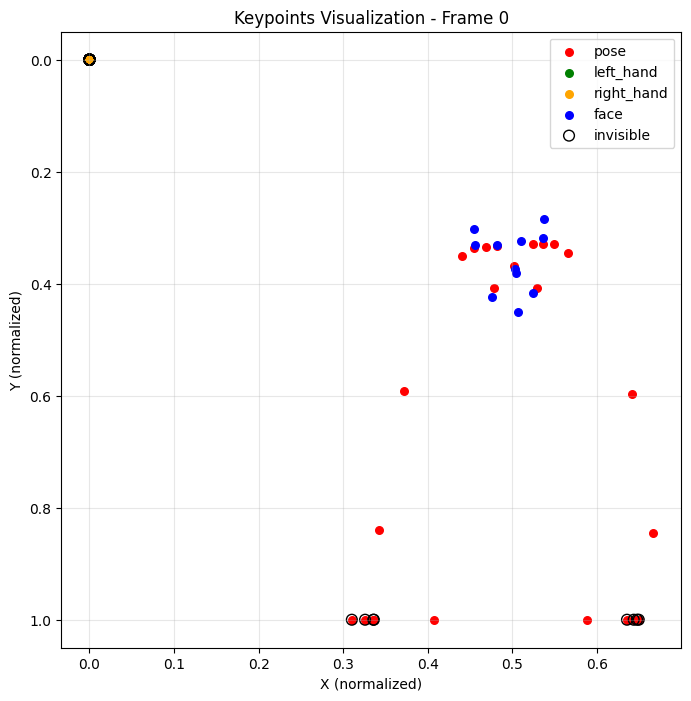

In [82]:
# Static visualization for a single frame (with visibility overlay)
plt.figure(figsize=(8, 8))
for name, idxs in keypoint_splits.items():
    plt.scatter(x_coords[idxs], y_coords[idxs], c=colors[name], label=name, s=30)

# Overlay visibility for this frame (mask True=visible). mask has 78 landmarks
vis = mask[frame_idx]
if vis.shape[0] == 78:
    invisible = np.where(~vis)[0]
    if invisible.size:
        plt.scatter(x_coords[invisible], y_coords[invisible], facecolors='none', edgecolors='k', s=60, label='invisible')

plt.gca().invert_yaxis()  # common for image coords
plt.title(f"Keypoints Visualization - Frame {frame_idx}")
plt.xlabel("X (normalized)")
plt.ylabel("Y (normalized)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [83]:
# Optional: inspect provided sample labels (if pandas available)
# - Shows first rows and basic uniquness stats
if pd is not None:
    labels_csv = ROOT / 'shared' / 'sample_processed' / 'labels.csv'
    if labels_csv.exists():
        labels = pd.read_csv(labels_csv)
        display(labels.head())
        print('Unique glosses:', labels['gloss'].nunique() if 'gloss' in labels else 'n/a')
        print('Unique categories:', labels['cat'].nunique() if 'cat' in labels else 'n/a')
    else:
        print(f"No labels.csv at {labels_csv}")
else:
    print('pandas not available; skipping labels preview')

file  gloss  cat  occluded
0  0\0.npz      0    0         1
1  0\1.npz      0    0         1
2  0\2.npz      0    0         1

Unique glosses: 1
Unique categories: 1


In [84]:
# Optional: dataset CSV stats if present (train/val labels)
# - Skips cleanly if files are not available
if pd is not None:
    train_csv = ROOT / 'data' / 'processed' / 'train_labels.csv'
    val_csv = ROOT / 'data' / 'processed' / 'val_labels.csv'
    if train_csv.exists() and val_csv.exists():
        train_df = pd.read_csv(train_csv)
        val_df = pd.read_csv(val_csv)
        print(f"Gloss range: {train_df['gloss'].min()} to {train_df['gloss'].max()}")
        print(f"Category range: {train_df['cat'].min()} to {train_df['cat'].max()}")
        print(f"Total unique glosses: {train_df['gloss'].nunique()}")
        print(f"Total unique categories: {train_df['cat'].nunique()}")
    else:
        print(f"train/val label CSVs not found at {train_csv} and {val_csv}; skipping.")
else:
    print('pandas not available; skipping label stats')

train/val label CSVs not found at c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\data\processed\train_labels.csv and c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\data\processed\val_labels.csv; skipping.


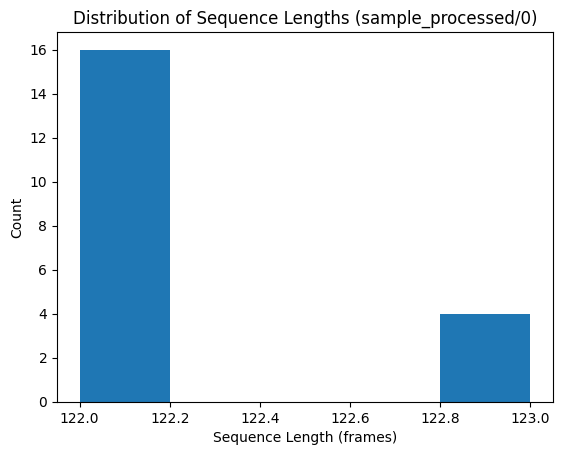

Min length: 122 | Max length: 123 | Mean: 122.2


In [85]:
# Optional: distribution of sequence lengths in the sample directory
# - Gives a quick sense of T variability across clips
npz_files = sorted(sample_dir.glob('*.npz'))
lengths = []
for p in npz_files:
    try:
        d = np.load(p)
        lengths.append(int(d['X'].shape[0]))
    except Exception as exc:
        print(f"Skip {p.name}: {exc}")

if lengths:
    plt.hist(lengths, bins=min(20, max(5, len(set(lengths)))))
    plt.xlabel('Sequence Length (frames)')
    plt.ylabel('Count')
    plt.title('Distribution of Sequence Lengths (sample_processed/0)')
    plt.show()
    print(f"Min length: {min(lengths)} | Max length: {max(lengths)} | Mean: {np.mean(lengths):.1f}")
else:
    print('No .npz files found to analyze sequence lengths.')

In [86]:
# Inspect keys present in the loaded NPZ and validate X2048 for IV3-GRU model
print('Keys in npz:', data.files)

# Enhanced X2048 validation for IV3-GRU model
if 'X2048' in data.files:
    X2048 = data['X2048']
    print(f'✅ X2048 present: {X2048.shape} {X2048.dtype}')
    
    # Validate shape and dtype for IV3-GRU requirements
    if X2048.ndim == 2 and X2048.shape[1] == 2048 and X2048.dtype == np.float32:
        print('✅ X2048 shape and dtype correct for IV3-GRU')
    else:
        print(f'❌ X2048 incorrect shape/dtype: expected [T, 2048] float32, got {X2048.shape} {X2048.dtype}')
    
    # Check temporal consistency with X
    if X2048.shape[0] == X.shape[0]:
        print('✅ X2048 temporal dimension matches X')
    else:
        print(f'❌ X2048 temporal mismatch: X has {X.shape[0]} frames, X2048 has {X2048.shape[0]}')
    
    # Additional quality checks
    if X2048.size and not np.isfinite(X2048).all():
        print('❌ X2048 contains non-finite values')
    else:
        print('✅ X2048 values are finite')
        
    # Check feature range (typical for InceptionV3 features)
    if X2048.size:
        print(f'X2048 range: [{X2048.min():.3f}, {X2048.max():.3f}]')
        print(f'X2048 mean: {X2048.mean():.3f}, std: {X2048.std():.3f}')
else:
    print('❌ X2048 missing - required for IV3-GRU model')

Keys in npz: ['X', 'X2048', 'mask', 'timestamps_ms', 'meta']
✅ X2048 present: (123, 2048) float32
✅ X2048 shape and dtype correct for IV3-GRU
✅ X2048 temporal dimension matches X
✅ X2048 values are finite
X2048 range: [0.000, 3.121]
X2048 mean: 0.353, std: 0.338


In [87]:
# Compact summary for quick QA
print({
    'T': int(X.shape[0]),
    'dims_per_frame': int(X.shape[1]),
    'mask_bits': int(mask.shape[1]),
    't_first_ms': int(timestamps[0]) if timestamps.size else None,
    't_last_ms': int(timestamps[-1]) if timestamps.size else None,
    'has_x2048': ('X2048' in data.files)
})

{'T': 123, 'dims_per_frame': 156, 'mask_bits': 78, 't_first_ms': 0, 't_last_ms': 4066, 'has_x2048': True}


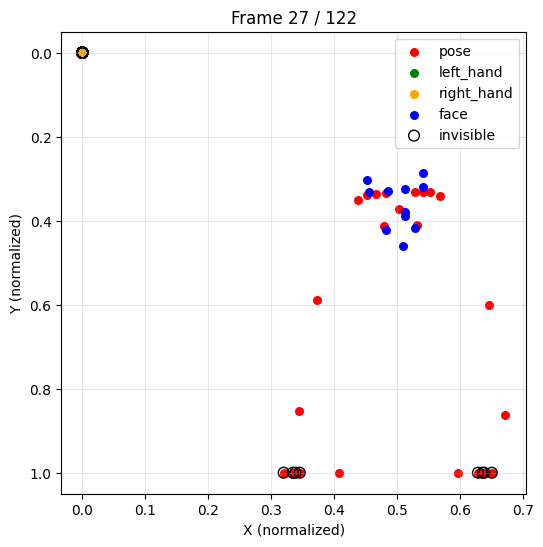

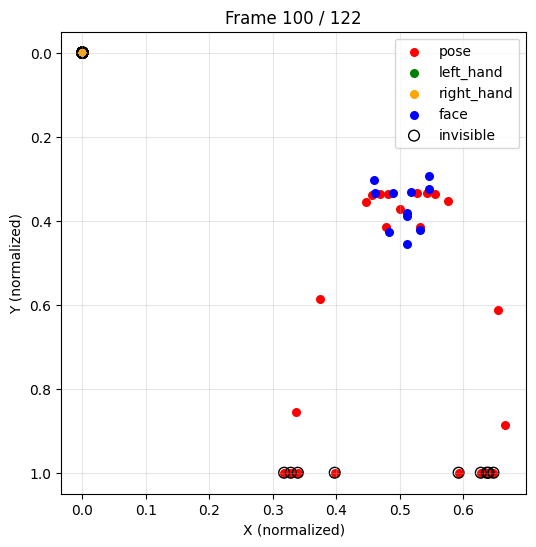

In [ ]:
# Helper: render a specific frame on demand
# - What: Plots keypoints for a single frame index using X/mask from the loaded NPZ
# - How to run: after running the loading cells above, call e.g. `plot_frame(0)` or `plot_frame(37)`

def plot_frame(frame_index: int, figsize=(6, 6)) -> None:
    """Render a single frame by index.

    Args:
        frame_index: Frame number to visualize (0..T-1)
        figsize: Matplotlib figure size
    """
    frame_index = max(0, min(int(frame_index), T - 1))
    frame = X[frame_index]
    x = frame[::2]
    y = frame[1::2]
    vis = mask[frame_index] if mask.shape[0] > frame_index else np.ones(78, dtype=bool)

    plt.figure(figsize=figsize)
    for name, idxs in keypoint_splits.items():
        plt.scatter(x[idxs], y[idxs], c=colors[name], label=name, s=30)
    # Mark invisible
    invisible = np.where(~vis)[0]
    if invisible.size:
        plt.scatter(x[invisible], y[invisible], facecolors='none', edgecolors='k', s=60, label='invisible')

    plt.gca().invert_yaxis()
    plt.title(f"Frame {frame_index} / {T-1}")
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage (uncomment to try):
plot_frame(27)
plot_frame(50)

In [89]:
# Comprehensive validation for both Transformer and IV3-GRU models
# - Uses the robust validation logic from preprocessing/validate_npz.py
# - Ensures the file meets all requirements for both model architectures
from preprocessing.validate_npz import validate_npz_file

print("=== COMPREHENSIVE MODEL VALIDATION ===")
print("Checking requirements for both Transformer and IV3-GRU models...")

errors = validate_npz_file(
    str(npz_path), 
    require_x2048=True,  # Require X2048 for IV3-GRU model
    check_parquet=False, 
    check_transformer=True,  # Check transformer requirements
    check_iv3=True  # Check IV3-GRU requirements
)

if errors:
    print('❌ Validation issues found:')
    for e in errors:
        print(' -', e)
    print('\n⚠️  File may not be suitable for training one or both models.')
else:
    print('✅ All validations passed for both Transformer and IV3-GRU models')
    print('✅ File is ready for training both model architectures')


=== COMPREHENSIVE MODEL VALIDATION ===
Checking requirements for both Transformer and IV3-GRU models...
✅ All validations passed for both Transformer and IV3-GRU models
✅ File is ready for training both model architectures


In [90]:
# Model readiness summary
# - Quick overview of which models can be trained with this data
print("\n=== MODEL READINESS SUMMARY ===")

# Check Transformer readiness
transformer_ready = (
    'X' in data.files and 
    data['X'].shape[1] == 156 and 
    data['X'].dtype == np.float32 and
    'mask' in data.files and
    data['mask'].shape[1] == 78 and
    data['mask'].dtype == np.bool_
)

# Check IV3-GRU readiness  
iv3_ready = (
    'X2048' in data.files and
    data['X2048'].shape[1] == 2048 and
    data['X2048'].dtype == np.float32 and
    data['X2048'].shape[0] == data['X'].shape[0]  # temporal consistency
)

print(f"🤖 Transformer model: {'✅ READY' if transformer_ready else '❌ NOT READY'}")
if transformer_ready:
    print(f"   - Keypoints: {data['X'].shape[1]}D features ✓")
    print(f"   - Mask: {data['mask'].shape[1]} keypoints ✓")
    print(f"   - Sequence length: {data['X'].shape[0]} frames ✓")
else:
    print("   - Missing or incorrect keypoint data (X) or mask")

print(f"🎥 IV3-GRU model: {'✅ READY' if iv3_ready else '❌ NOT READY'}")
if iv3_ready:
    print(f"   - Features: {data['X2048'].shape[1]}D InceptionV3 features ✓")
    print(f"   - Temporal: {data['X2048'].shape[0]} frames ✓")
    print(f"   - Data type: {data['X2048'].dtype} ✓")
else:
    print("   - Missing or incorrect X2048 features")

# Overall assessment
if transformer_ready and iv3_ready:
    print("\n🎉 EXCELLENT: This file is ready for training both model architectures!")
elif transformer_ready or iv3_ready:
    print(f"\n⚠️  PARTIAL: This file is ready for {'Transformer' if transformer_ready else 'IV3-GRU'} only")
else:
    print("\n❌ NOT READY: This file has issues preventing training of either model")



=== MODEL READINESS SUMMARY ===
🤖 Transformer model: ✅ READY
   - Keypoints: 156D features ✓
   - Mask: 78 keypoints ✓
   - Sequence length: 123 frames ✓
🎥 IV3-GRU model: ✅ READY
   - Features: 2048D InceptionV3 features ✓
   - Temporal: 123 frames ✓
   - Data type: float32 ✓

🎉 EXCELLENT: This file is ready for training both model architectures!


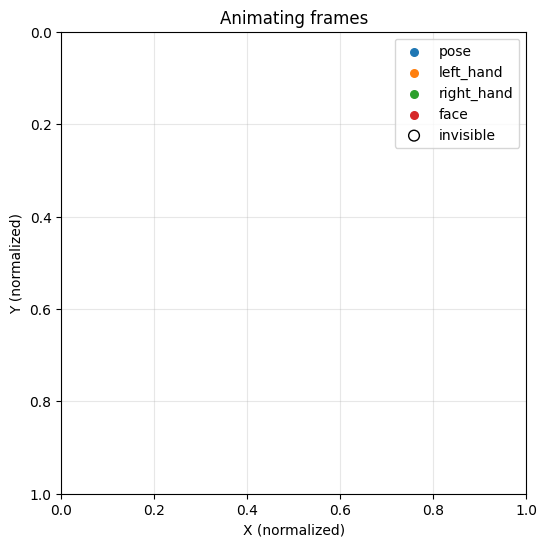

In [91]:
# Matplotlib animation fallback (no ipywidgets required)
# - Renders inline as JavaScript for reliability in notebook environments
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)  # invert y
ax.set_xlabel('X (normalized)')
ax.set_ylabel('Y (normalized)')
ax.grid(True, alpha=0.3)

# Create one scatter per split and one for invisible points (updated per frame)
split_names = list(keypoint_splits.keys())
split_indices = [keypoint_splits[k] for k in split_names]
scatters = [ax.scatter([], [], s=30, label=name) for name in split_names]
inv_scatter = ax.scatter([], [], facecolors='none', edgecolors='k', s=60, label='invisible')
ax.legend(loc='upper right')

def init():
    for s in scatters:
        s.set_offsets(np.empty((0, 2)))
    inv_scatter.set_offsets(np.empty((0, 2)))
    ax.set_title('Animating frames')
    return scatters + [inv_scatter]

def update(i):
    frame = X[i]
    x = frame[::2]
    y = frame[1::2]
    vis = mask[i] if mask.shape[0] > i else np.ones(78, dtype=bool)

    for s, idxs in zip(scatters, split_indices):
        coords = np.column_stack([x[idxs], y[idxs]])
        s.set_offsets(coords)

    inv = np.where(~vis)[0]
    if inv.size:
        inv_coords = np.column_stack([x[inv], y[inv]])
    else:
        inv_coords = np.empty((0, 2))
    inv_scatter.set_offsets(inv_coords)

    ax.set_title(f'Frame {i} / {T-1}')
    return scatters + [inv_scatter]

ani = animation.FuncAnimation(fig, update, frames=T, init_func=init, interval=40, blit=False, repeat=True)
# Render inline as JS animation (works in most notebook environments)
if HTML is not None:
    HTML(ani.to_jshtml())
else:
    print("Animation created. In Jupyter environments, this would display as an interactive animation.")
    plt.show()


In [92]:
# Force display the animation (fix for disappearing animation)
from IPython.display import display

# Force display the animation
try:
    display(HTML(ani.to_jshtml()))
    print("✅ Animation displayed successfully!")
except Exception as e:
    print(f"❌ Animation display failed: {e}")
    print("Try running the previous cell again or check your Jupyter environment.")


✅ Animation displayed successfully!


## Option to Download/Save Keypoint Visualization Animation

In [93]:
# Save keypoint animation as MP4 video
# - Creates a high-quality MP4 animation of the keypoint visualization
# - Uses matplotlib's animation writer to save frames as video
# - Configurable frame rate and quality settings
# - Saves to shared/sample_animations/ folder with descriptive names

import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import os

def save_keypoint_animation_as_mp4(
    X, mask, keypoint_splits, colors, 
    base_filename="5",  # Original file name (e.g., "0" from "0.npz") # ‼️ Change accordingly
    animation_type="animation",  # Type: "animation", "detailed", "preview", "slow_motion"
    fps=30,
    dpi=100,
    figsize=(8, 8)
):
    """
    Save keypoint animation as MP4 video file.
    
    Args:
        X: Keypoint data [T, 156]
        mask: Visibility mask [T, 78] 
        keypoint_splits: Dictionary mapping body parts to keypoint indices
        colors: Dictionary mapping body parts to colors
        base_filename: Base filename (e.g., "0" from "0.npz")
        animation_type: Type of animation ("animation", "detailed", "preview", "slow_motion")
        fps: Frames per second for the video
        dpi: Dots per inch for video quality
        figsize: Figure size (width, height)
    """
    T = X.shape[0]
    
    # Create output directory
    output_dir = ROOT / 'shared' / 'sample_animations'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Generate output filename
    output_path = output_dir / f"{base_filename}_{animation_type}.mp4"
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)  # invert y-axis for image coordinates
    ax.set_xlabel('X (normalized)')
    ax.set_ylabel('Y (normalized)')
    ax.grid(True, alpha=0.3)
    ax.set_title('Keypoint Animation')
    
    # Create scatter plots for each body part
    split_names = list(keypoint_splits.keys())
    split_indices = [keypoint_splits[k] for k in split_names]
    scatters = []
    
    for i, (name, idxs) in enumerate(zip(split_names, split_indices)):
        scatter = ax.scatter([], [], s=30, c=colors[name], label=name, alpha=0.8)
        scatters.append(scatter)
    
    # Create scatter for invisible points
    inv_scatter = ax.scatter([], [], facecolors='none', edgecolors='k', s=60, label='invisible', alpha=0.6)
    ax.legend(loc='upper right')
    
    def init():
        """Initialize animation frame."""
        for s in scatters:
            s.set_offsets(np.empty((0, 2)))
        inv_scatter.set_offsets(np.empty((0, 2)))
        return scatters + [inv_scatter]
    
    def update(frame_idx):
        """Update animation frame."""
        frame = X[frame_idx]
        x = frame[::2]
        y = frame[1::2]
        vis = mask[frame_idx] if mask.shape[0] > frame_idx else np.ones(78, dtype=bool)
        
        # Update each body part scatter plot
        for scatter, idxs in zip(scatters, split_indices):
            coords = np.column_stack([x[idxs], y[idxs]])
            scatter.set_offsets(coords)
        
        # Update invisible points
        inv = np.where(~vis)[0]
        if inv.size:
            inv_coords = np.column_stack([x[inv], y[inv]])
        else:
            inv_coords = np.empty((0, 2))
        inv_scatter.set_offsets(inv_coords)
        
        # Update title with frame info
        ax.set_title(f'Keypoint Animation - Frame {frame_idx+1} / {T}')
        
        return scatters + [inv_scatter]
    
    # Create animation
    print(f"Creating animation with {T} frames at {fps} FPS...")
    ani = animation.FuncAnimation(
        fig, update, frames=T, init_func=init, 
        interval=1000//fps, blit=False, repeat=True
    )
    
    # Save as MP4
    print(f"Saving animation to: {output_path}")
    try:
        # Use FFMpegWriter for MP4 output
        writer = FFMpegWriter(fps=fps, metadata=dict(artist='Keypoint Visualizer'), bitrate=1800)
        ani.save(str(output_path), writer=writer, dpi=dpi)
        print(f"✅ Successfully saved animation as MP4: {output_path}")
        
        # Get file size
        file_size = os.path.getsize(output_path)
        print(f"📁 File size: {file_size / (1024*1024):.2f} MB")
        
    except Exception as e:
        print(f"❌ Error saving MP4: {e}")
        print("💡 Make sure you have ffmpeg installed:")
        print("   - Windows: Download from https://ffmpeg.org/download.html")
        print("   - Or install via conda: conda install ffmpeg")
        print("   - Or install via pip: pip install ffmpeg-python")
        
        # Fallback: save as GIF
        gif_path = output_path.with_suffix('.gif')
        print(f"🔄 Trying fallback GIF format: {gif_path}")
        try:
            ani.save(str(gif_path), writer='pillow', fps=fps)
            print(f"✅ Successfully saved as GIF: {gif_path}")
        except Exception as gif_error:
            print(f"❌ GIF fallback also failed: {gif_error}")
    
    plt.close(fig)  # Close figure to free memory
    return ani

# Generate the MP4 animation
# Extract base filename from the loaded NPZ file
base_filename = npz_path.stem  # Gets "0" from "0.npz"

print("🎬 Generating keypoint animation as MP4...")
print(f"📁 Base filename: {base_filename}")
print(f"📁 Output directory: {ROOT / 'shared' / 'sample_animations'}")

animation_obj = save_keypoint_animation_as_mp4(
    X, mask, keypoint_splits, colors,
    base_filename=base_filename,
    animation_type="animation",
    fps=30,  # 30 FPS for smooth playback
    dpi=100,  # High quality
    figsize=(10, 10)  # Larger figure for better visibility
)


🎬 Generating keypoint animation as MP4...
📁 Base filename: 5
📁 Output directory: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations
Creating animation with 123 frames at 30 FPS...
Saving animation to: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations\5_animation.mp4
✅ Successfully saved animation as MP4: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations\5_animation.mp4
📁 File size: 0.36 MB


## Option to Download/Save Custom Animations (Detailed, Preview, Slow Motion)

In [94]:
# Additional animation options and customization
# - Create animations with different settings
# - Save multiple versions (different speeds, quality, etc.)

def create_custom_animation(
    X, mask, keypoint_splits, colors,
    base_filename="1",  # Original file name
    animation_type="detailed",  # Type of animation
    fps=15,  # Slower for better observation
    dpi=150,  # Higher quality
    figsize=(12, 12),  # Larger figure
    show_timestamps=True,
    show_frame_numbers=True
):
    """
    Create a customized keypoint animation with additional features.
    
    Args:
        X: Keypoint data [T, 156]
        mask: Visibility mask [T, 78]
        keypoint_splits: Dictionary mapping body parts to keypoint indices
        colors: Dictionary mapping body parts to colors
        base_filename: Base filename (e.g., "0" from "0.npz")
        animation_type: Type of animation ("detailed", "preview", "slow_motion")
        fps: Frames per second
        dpi: Dots per inch for quality
        figsize: Figure size
        show_timestamps: Whether to show timestamps in title
        show_frame_numbers: Whether to show frame numbers
    """
    T = X.shape[0]
    
    # Create output directory
    output_dir = ROOT / 'shared' / 'sample_animations'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Generate output filename
    output_path = output_dir / f"{base_filename}_{animation_type}.mp4"
    
    # Create figure with subplots for additional info
    if show_timestamps:
        fig, (ax_main, ax_info) = plt.subplots(1, 2, figsize=(figsize[0] + 4, figsize[1]))
        ax_info.axis('off')
    else:
        fig, ax_main = plt.subplots(figsize=figsize)
        ax_info = None
    
    # Setup main plot
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(1, 0)
    ax_main.set_xlabel('X (normalized)')
    ax_main.set_ylabel('Y (normalized)')
    ax_main.grid(True, alpha=0.3)
    
    # Create scatter plots
    split_names = list(keypoint_splits.keys())
    split_indices = [keypoint_splits[k] for k in split_names]
    scatters = []
    
    for name, idxs in zip(split_names, split_indices):
        scatter = ax_main.scatter([], [], s=40, c=colors[name], label=name, alpha=0.8)
        scatters.append(scatter)
    
    inv_scatter = ax_main.scatter([], [], facecolors='none', edgecolors='k', s=80, label='invisible', alpha=0.6)
    ax_main.legend(loc='upper right')
    
    def init():
        for s in scatters:
            s.set_offsets(np.empty((0, 2)))
        inv_scatter.set_offsets(np.empty((0, 2)))
        return scatters + [inv_scatter]
    
    def update(frame_idx):
        frame = X[frame_idx]
        x = frame[::2]
        y = frame[1::2]
        vis = mask[frame_idx] if mask.shape[0] > frame_idx else np.ones(78, dtype=bool)
        
        # Update scatter plots
        for scatter, idxs in zip(scatters, split_indices):
            coords = np.column_stack([x[idxs], y[idxs]])
            scatter.set_offsets(coords)
        
        # Update invisible points
        inv = np.where(~vis)[0]
        if inv.size:
            inv_coords = np.column_stack([x[inv], y[inv]])
        else:
            inv_coords = np.empty((0, 2))
        inv_scatter.set_offsets(inv_coords)
        
        # Update title
        title_parts = []
        if show_frame_numbers:
            title_parts.append(f'Frame {frame_idx+1} / {T}')
        if show_timestamps and 'timestamps_ms' in globals():
            time_sec = timestamps[frame_idx] / 1000.0
            title_parts.append(f'Time: {time_sec:.2f}s')
        
        ax_main.set_title(' | '.join(title_parts) if title_parts else 'Keypoint Animation')
        
        # Update info panel if available
        if ax_info is not None:
            ax_info.clear()
            ax_info.axis('off')
            
            # Show visibility statistics
            visible_count = vis.sum()
            total_count = len(vis)
            coverage = visible_count / total_count * 100
            
            info_text = f"""
            Frame: {frame_idx+1} / {T}
            Time: {timestamps[frame_idx]/1000:.2f}s
            Visible: {visible_count}/{total_count} ({coverage:.1f}%)
            
            Body Parts:
            • Pose: {vis[:25].sum()}/25
            • Left Hand: {vis[25:46].sum()}/21  
            • Right Hand: {vis[46:67].sum()}/21
            • Face: {vis[67:78].sum()}/11
            """
            
            ax_info.text(0.1, 0.9, info_text, transform=ax_info.transAxes, 
                        fontsize=10, verticalalignment='top', fontfamily='monospace')
        
        return scatters + [inv_scatter]
    
    # Create animation
    ani = animation.FuncAnimation(
        fig, update, frames=T, init_func=init,
        interval=1000//fps, blit=False, repeat=True
    )
    
    # Save as MP4
    print(f"🎬 Creating custom animation: {output_path}")
    print(f"   - FPS: {fps}")
    print(f"   - DPI: {dpi}")
    print(f"   - Size: {figsize}")
    
    try:
        writer = FFMpegWriter(fps=fps, metadata=dict(artist='Keypoint Visualizer'), bitrate=2000)
        ani.save(str(output_path), writer=writer, dpi=dpi)
        print(f"✅ Custom animation saved: {output_path}")
        
        file_size = os.path.getsize(output_path)
        print(f"📁 File size: {file_size / (1024*1024):.2f} MB")
        
    except Exception as e:
        print(f"❌ Error saving custom MP4: {e}")
        # Fallback to GIF
        gif_path = output_path.with_suffix('.gif')
        try:
            ani.save(str(gif_path), writer='pillow', fps=fps)
            print(f"✅ Saved as GIF fallback: {gif_path}")
        except Exception as gif_error:
            print(f"❌ GIF fallback failed: {gif_error}")
    
    plt.close(fig)
    return ani

# Create different versions of the animation
print("🎨 Creating multiple animation versions...")
print(f"📁 Base filename: {base_filename}")
print(f"📁 Output directory: {ROOT / 'shared' / 'sample_animations'}")

# 1. High-quality detailed version
print("\n1️⃣ Creating high-quality detailed version...")
create_custom_animation(
    X, mask, keypoint_splits, colors,
    base_filename=base_filename,
    animation_type="detailed",
    fps=15, dpi=150, figsize=(12, 8),
    show_timestamps=True, show_frame_numbers=True
)

# 2. Fast preview version
print("\n2️⃣ Creating fast preview version...")
create_custom_animation(
    X, mask, keypoint_splits, colors,
    base_filename=base_filename,
    animation_type="preview",
    fps=30, dpi=100, figsize=(8, 8),
    show_timestamps=False, show_frame_numbers=True
)

# 3. Slow motion version for detailed analysis
print("\n3️⃣ Creating slow motion version...")
create_custom_animation(
    X, mask, keypoint_splits, colors,
    base_filename=base_filename,
    animation_type="slow_motion",
    fps=10, dpi=120, figsize=(10, 10),
    show_timestamps=True, show_frame_numbers=True
)

print("\n🎉 All animation versions created successfully!")
print(f"📁 Check {ROOT / 'shared' / 'sample_animations'} for the generated video files.")


🎨 Creating multiple animation versions...
📁 Base filename: 5
📁 Output directory: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations

1️⃣ Creating high-quality detailed version...
🎬 Creating custom animation: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations\5_detailed.mp4
   - FPS: 15
   - DPI: 150
   - Size: (12, 8)
✅ Custom animation saved: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations\5_detailed.mp4
📁 File size: 0.73 MB

2️⃣ Creating fast preview version...
🎬 Creating custom animation: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations\5_preview.mp4
   - FPS: 30
   - DPI: 100
   - Size: (8, 8)
✅ Custom animation saved: c:\Users\ricaj\OneDrive\Documents\GitHub\fslr-transformer-vs-iv3gru\shared\sample_animations\5_preview.mp4
📁 File size: 0.41 MB

3️⃣ Creating slow motion version...
🎬 Creating custom animation: c: